#Homework 2
To have a better understanding of the theory behind the exercises solved, please have a look at the report inside the directory HW2.

##Problem 1

The first part of this assignment consists in studying a single particle performing a continuous-time random walk in the network described by the graph in the figure below and with the following transition rate matrix.


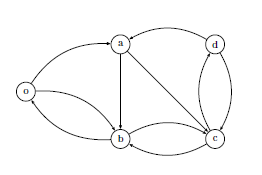
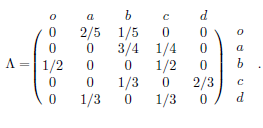

Your task is to simulate the particle moving around in the network in continuous time according to the transition rate matrix $Λ$.

In [23]:
import networkx as nx
import numpy as np
from numpy.random import choice, rand 


Transition matrix lambda:
[[0.         0.4        0.2        0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.33333333 0.         0.33333333 0.        ]]


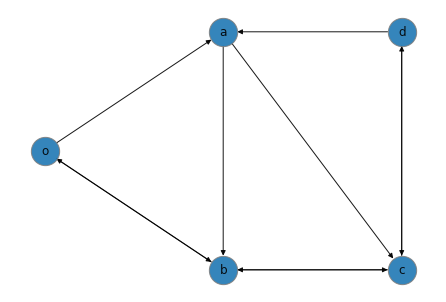

In [24]:
#Generate the graph and transition-rate matrix lambda

G = nx.DiGraph()
G.add_edges_from([('o','a'),('o','b'),
                  ('a','b'),('a','c'),
                  ('b','c'),('b','o'),
                  ('c','b'),('c','d'),
                  ('d','a'),('d','c')])

lambda_matrix =   np.array([[0,   2/5, 1/5, 0,   0],
                            [0,   0,   3/4, 1/4, 0],
                            [1/2, 0,   0,   1/2, 0],
                            [0,   0,   1/3, 0,   2/3],
                            [0,   1/3, 0,   1/3, 0]])

#decide the position of vertices to clearly show them and decide options for the
#layout of the graph
pos_vertices = {'o': (-1, 0), 'a':(0, 1), 'b':(0, -1), 'c':(1, -1), 'd':(1, 1)}
options = {"edgecolors": "tab:gray", "node_size": 800, "alpha": 0.9}

#Show the graph and print the transition-rate matrix
nx.draw(G, pos = pos_vertices, with_labels=True, **options)
print("Transition matrix lambda:")
print(lambda_matrix)

In [25]:
#1st approach: global Poisson clock -> Q, Qcum, w*
# 2nd approach: local Poisson clock-> P, Pcum, wi

#Construct matrices and vectors according to the theory:
w = np.sum(lambda_matrix, axis=1) #sum over rows, I got the wi for each node
w_star = np.max(w)
D = np.diag(w)
P = np.linalg.inv(D) @ lambda_matrix
P_cum = np.cumsum(P, axis=1)    #sum over the row, they have to sum to 1 since are all probabilitites

Q = lambda_matrix/w_star 
Q = Q + np.diag(np.ones(len(w))-np.sum(Q,axis=1))
Q_cum = np.cumsum(Q, axis=1)

#estimate pi_bar
values,vectors = np.linalg.eig(Q.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print("pi_bar=", pi_bar)

pi_bar= [0.18518519 0.14814815 0.22222222 0.22222222 0.22222222]


###**a) What is, according to the simulations, the average time it takes a particle that starts in node a to leave the node and then return to it?**

In [26]:
#To evaluate several statistics about random walks starting from and finishing 
#in different nodes we write for the sake of simplicity the RandomWalks function

def RandomWalks(x0, xd, n_simulations, n_steps, w, w_star, M_cum, clock):
  """
  x0: starting node
  xd: end node
  n_simulations: number of simulations desired to execute the random walk
  w: sum of transition-rate matrix over rows 
  """
  #To compute the average of the random walk we use a vector return_times where
  #each element contains the time spent for each random walk spent
  return_times = np.zeros(n_simulations)    

  #Depending on the kind of clock, you compute the time elapsed between one
  #time istant and another according to the following formulas coming from
  #the theory

  if clock == 'local':
    t_next = -np.log(np.random.rand())/w[x0]  #generate t_next exp rv.
  elif clock == 'global':
    t_next = -np.log(np.random.rand())/w_star
  else:
    print("Specify the kind of clock you are using (local or global)")

  #To properly compute the average time spent during the random walk we need to
  #simulate with an high number of simultations. We take n_simultations = 1000.
  #The walk can finishes due to 2 reasons: we have reached the desired destination+
  #xd or, in the worst case if we have not reached the destination we set a 
  #maximum number of steps allowed to avoid an infinite loop. To do this we
  #use a flag variable 'exit'

  for sim in range(n_simulations):

    exit = False

    #To keep track of the walk we use an array pos whose elements contains the
    #nodes (0,1,2,3,4) visited at each step. We initialize it with a zero array of n_steps
    #elements to handle the worst case.
    pos = np.zeros(n_steps, dtype=int)    

    #We start from x0: index of source node
    pos[0] = x0                           

    #We use an array transition_times to store the times in which we have jumped
    #into a new node
    transition_times = np.zeros(n_steps) 

    for step in range(1, n_steps):
      
      #exit = False -> not arrived in xd yet
      if exit == False:

        #(Hint 2 in the homework)
        
        #Given the probability distribution M_cum, to choose the next neighbor
        #to visit we can compare the probability distribution M_cum with an 
        #uniform random variable, take the pos[step-1] row of the matrix M_cum
        #take a number x immediately greater than aanother number u uniformly 
        #generated in the [0, 1] interval. The index of number x will be the
        #index of the next node to visit.

        pos[step] = np.argwhere(M_cum[pos[step-1]] > np.random.rand())[0]
        
        # store the time instant qat which we will arrive in next node
        transition_times[step] = transition_times[step-1] + t_next

        # compute the waiting time to the next transition
        if clock == 'local':
          t_next = -np.log(np.random.rand())/w[pos[step]] 
        else:
          t_next = -np.log(np.random.rand())/w_star 

        
        #if the next jump will arrive to the destination desired the walk finishes 
        #(if x0 = xd we ignore the case self loop x0->x0 but we only allow
        #x0-> ... -> xd where ... represent at least one node)

        if pos[step] == xd and step != x0:

          #update with final position and setting the flag to exit from the for
          pos[step] = xd #chiudo ciclo
          exit = True
                
      else:
        break

    #store for each simulation the time needed to compute the walk x0->xd
    #on which np.mean() will be applied to compute the average time
    
    return_times[sim] = transition_times[step-1]
      
  return pos, np.mean(return_times), transition_times, step


In [27]:
import matplotlib.pyplot as plt

#Initialize parameters for the random walk
n_simulations = 1000
n_steps = 1000
x0 = xd = 1 #random walk starts and finishes in a

pos, average_time, transition_times, num_jumps= RandomWalks(x0,xd, n_simulations, n_steps, w, w_star, Q_cum, "global")

# Uncomment to plot the trajectory for the first num_jumps jumps in the last simulation
# print("Last simulation:")
# plt.plot(transition_times[0:num_jumps], pos[0:num_jumps], 'bo')
# plt.title(f'Last simulation: Trajectory is {num_jumps} jumps long')

#Uncomment to explicitely see the path
#print(pos[:num_jumps], transition_times[:num_jumps])

print(f"Simulating {n_simulations} times a random walk starting from {x0} to {xd} I get an average time equal to {average_time:.2f}")


Simulating 1000 times a random walk starting from 1 to 1 I get an average time equal to 6.96


###**b) How does the result in a) compare to the theoretical return-time $E_a[T_a^{+}]$? (Include a description of how this is computed.)**

In [28]:
"""To compute the theoretical results we need to compute the left eigen values
and eigen vectors"""

values,vectors = np.linalg.eig(Q.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
#print("pi_bar=", pi_bar)

exp_return_time = 1 / (pi_bar*w)

# node a is at index 1, so we print the element 1 of the vector
print(f"Expected return time: {exp_return_time[1]} s ")

#Compute the relative error between theoretical and simulated results
error = abs(average_time - exp_return_time[1])/exp_return_time[1]
print(f"Relative error: {error*100:.2f}%.")


Expected return time: 6.75 s 
Relative error: 3.16%.


###**c) What is, according to the simulations, the average time it takes to move from node o to node d?**

In [29]:
#Equal to point a, the only difference are x0 and xd which in this case are
#0 and 4 respectively.

x0 = 0 #node o
xd = 4 #node d
pos, average_time, transition_times, num_jumps = RandomWalks(x0,xd, n_simulations, n_steps, w, w_star, Q_cum, "global")
print(f"Simulating {n_simulations} times a random walk starting from {x0} to {xd} I get an average time equal to {average_time:.2f}")


Simulating 1000 times a random walk starting from 0 to 4 I get an average time equal to 8.80


###**d) How does the result in c) compare to the theoretical hitting-time Eo[Td]? (Describe also how this is computed.)**

In [30]:
num_nodes = len(G.nodes)

x0 = 0 #o
xd = 4 #d

R = [node for node in range(0,num_nodes) if node != xd]
len_R = num_nodes - 1            #1 since the set S contains only one element (d)

hatP = P[np.ix_(R, R )]
xhat = np.linalg.solve((np.identity(len_R)-hatP),np.ones(len_R)/w[R])

hitting_s = np.zeros(num_nodes)
hitting_s[R] = xhat

print(f"Hitting time: {hitting_s[x0]:.2f} s ")

error = abs(average_time - hitting_s[x0])/hitting_s[0]
print(f"Relative error: {error*100:.2f}%.")

Hitting time: 8.79 s 
Relative error: 0.15%.


###**e) Interpret the matrix $Λ$ as the weight matrix of a graph $\mathcal{G} = (\mathcal{V}, \mathcal{E},Λ)$, and simulate the FrenchDeGroot dynamics on $\mathcal{G}$ with an arbitrary initial condition $x(0)$. Does the dynamics converge to a consensus state? Motivate your answer.**




The graph is strongly connected and aperiodic so the French-DeGroot theorem can be applied.


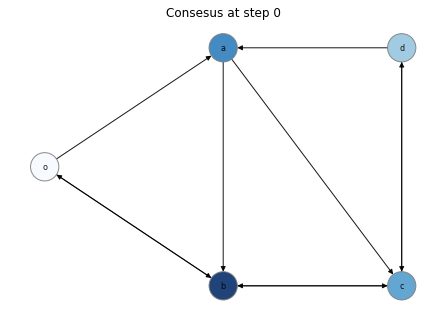

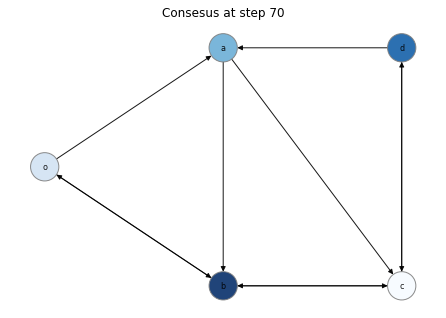

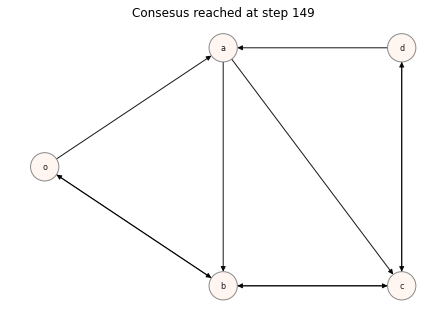

The initial state is [0.825205   0.05226691 0.44161731 0.94516699 0.79212681]
Consensus: [0.63473819 0.63473819 0.63473819 0.63473819 0.63473819]


In [31]:
#Let's evalutate if both conditions of FDG theorem are satisfied:

#Check if the graph is strongly connected and aperiodic:
if nx.algorithms.is_strongly_connected(G) and nx.is_aperiodic(G):
  print("The graph is strongly connected and aperiodic so the French-DeGroot theorem can be applied.")

#Uncomment to plot the condensation graph
#CG = nx.algorithms.components.condensation(G)
#plt.figure()
#nx.draw(CG, **options)
#print(nx.is_aperiodic(CG))

#If both conditions are satisfied, let's see to which distribution converges

# Assign initial opinion to nodes and run the dynamics
x = np.random.rand(len(G.nodes))
initial_state = x

# Construct P
W = nx.adjacency_matrix(G) 
W = W.toarray() 
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W


for step in range(n_simulations):
  
  #compute the evolution of opinion: x = Px
  x = P@x
  nodecolor = x*1000

  #I assume to reach consesus when all the agents (nodes) have the same value
  #with a precision of 10 digits, we iterate untill they differ
  if np.all(nodecolor.round(decimals=10)[0] == nodecolor.round(decimals=10)) == False:

    #Plot the evolution of initial and middle step  
    if step == 0 or step == 70:
      nx.draw(G,pos_vertices,
         nodelist=list(G.nodes()), 
         # node's color reflects centrality values (higher dc = darker color)
         node_color=nodecolor.round(decimals=10),
         font_size=8,
         # node's colors are on the red scale
         cmap=plt.cm.Blues, **options, with_labels = True) 
      plt.title(f'Consesus at step {step}')
      plt.show()
  else:
    break

nx.draw(G,pos_vertices,
         nodelist=list(G.nodes()), 
         # node's color reflects centrality values (higher dc = darker color)
         node_color=nodecolor.round(decimals=10),
         font_size=8,
         # node's colors are on the red scale
         cmap=plt.cm.Reds, **options, with_labels=True) 
plt.title(f'Consesus reached at step {step}')
plt.show()

print(f"The initial state is {initial_state}")
print(f"Consensus: {x}")



###**f) Assume that the initial state of the dynamics for each node $i \in \mathcal{V}$ is given by $x_i(0) = \xi_i$ where $(\xi_i)_{i ϵV}$ are i.i.d random variables with variance $\sigma^2$. Compute the variance of the consensus value, and compare your results with numerical simulations.**

In [32]:
#Compute the variance of the consesus (crowd) first by simulations and then 
#by theoretical results"""

#Simulations

#list containing the variance of each simulation
var_simulations = []

#In the following we will execute n_simulations and for each of them we will
#choose the initial state according to an uniform distribution which is defined
#on [0,1], this means that each node (agent) has mean = 0 and variance = 1/12

var_individual = 1/12

for sim in range(n_simulations):
  x = np.random.rand(len(G.nodes))
  for step in range(n_steps):
    x = P @ x
  var_simulations.append((1/2 - np.mean(x))*(1/2 - np.mean(x)))

print("Expected variance of the node states:", 1/12)
print(f"Empirical variance of the consensus state: {np.mean(var_simulations)}")  

#Now we compute the theoretical value

eigenval, eigenvec = np.linalg.eig(P.T)
for index in [i for i in range(len(G)) if np.isclose(eigenval[i],1)]: 
  pi = eigenvec[:,index].real
  pi = pi/np.sum(pi)
  pi_square=np.square(pi)

var_crowd=var_individual*np.sum(pi_square) #crowd level
print(f"The theoretical variance of the conseus is {var_crowd}")

Expected variance of the node states: 0.08333333333333333
Empirical variance of the consensus state: 0.019237676974630646
The theoretical variance of the conseus is 0.018707482993197275


###**g) Remove the edges $(d; a)$ and $(d; c)$. Describe and motivate the asymptotic behaviour of the dynamics. If the dynamics converges to a consensus state, how is the consensus value related to the initial condition $x(0)$ Assume that the initial state of the dynamics for each node $i \in \mathcal{V}$ is given by $x_i(0) = xi_i$, where $\{\xi_i\}_{i\in\mathcal{V}}$ are i.i.d random variables with variance $\sigma^2$. Compute the variance of the consensus value. Motivate your answer.**

The graph is aperiodic but not strongly connected so the French-DeGroot theorem cannot be applied.


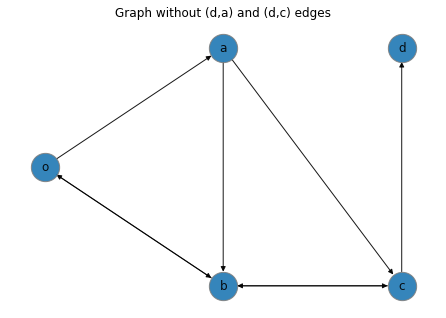

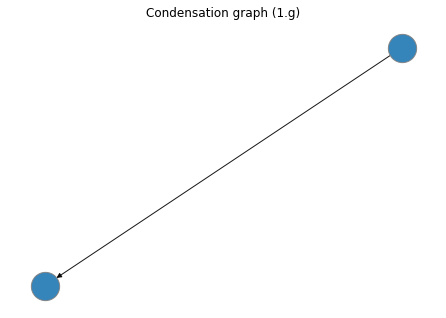

Initial state[0.06394853 0.52404776 0.34710536 0.82190709 0.77095226]
Theoretical consensus 0.7709522589150837
Simulation consensus [0.77095226 0.77095226 0.77095226 0.77095226 0.77095226]


In [33]:
#Remove edges
G.remove_edges_from([('d','a'), ('d','c')])

#delete non-empty entries in transition  matrix after removing edges (d,a) and
#(d,c)
lambda_matrix[4][1] = lambda_matrix[4][3] = 0

plt.figure()
nx.draw(G, pos = pos_vertices, with_labels=True, **options)
plt.title("Graph without (d,a) and (d,c) edges")

#Again, let's see if the FDG conditions are satisifed to see if a possible
#consensus can be reached

sc = nx.algorithms.is_strongly_connected(G)
a = nx.is_aperiodic(G)

#check  FDG conditions
CG = nx.algorithms.components.condensation(G)
if nx.algorithms.is_strongly_connected(G) and nx.is_aperiodic(G):
  print("The graph is strongly connected and aperiodic so the French-DeGroot theorem can be applied.")
elif sc == True and a == False: #graph is strongly connected but not aperiodic
  print("The graph is strongly connected but not aperiodic so the French-DeGroot theorem cannot be applied.")
else:
  print("The graph is aperiodic but not strongly connected so the French-DeGroot theorem cannot be applied.")

#Let's compute the condensation graph of G and see if it has only one sink
plt.figure(2)
nx.draw(CG, **options)
plt.title("Condensation graph (1.g)")
plt.show()

#The condensation graph has two components (o-a-b) and (c-d) which is not an
#aperiodic sink, so in order to have convergence we add a self-loop on d to 
#transorm it into an aperiodic one.

# Construct new P 
W = nx.adjacency_matrix(G)    
W = W.toarray()               
W[4][4] = 1                   #add self loop
degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

#Simulation
x_0 = np.random.rand(len(G.nodes))
x=x_0
for step in range(n_simulations):
  x = P @ x

#Now let's see if this consesus is equal to pibar.T*x0 as in theory
#First we have to notice that d has no outgoing edges so in this case we need
#to add a self loop to properly compute the invariant distribution pi

eigenval, eigenvec = np.linalg.eig(P.T)
for index in [i for i in range(len(G)) if np.isclose(eigenval[i],1)]: 
  pi = eigenvec[:,index].real
  pi = pi/np.sum(pi)
  pi_square=np.square(pi)

print(f"Initial state{x_0}")
print(f"Theoretical consensus {pi.T@x_0}")
print(f"Simulation consensus {x}")

# #Ripristinate the original graph
G.add_edges_from([('d', 'a'), ('d','c')])
# plt.figure()
# nx.draw(G, pos_vertices, **options)

###**h) How does the result in a) compare to the theoretical return-time $\mathbb{E}_{a}[T^{+}_a]+$? (Include a description of how this is computed.)**

The graph is aperiodic but not strongly connected so the French-DeGroot theorem cannot be applied.


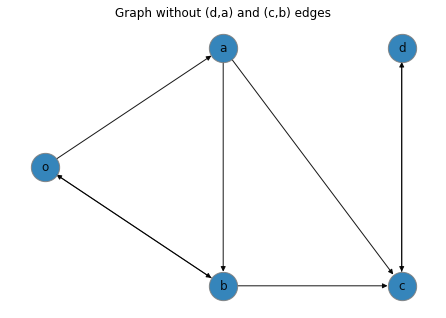

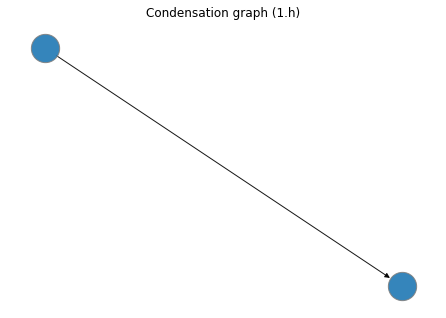

Initial state[0.23984983 0.61507683 0.17919004 0.66467737 0.06879975]
Theoretical consensus 0.06879975414869532
Simulation consensus [0.06879975 0.06879975 0.06879975 0.06879975 0.06879975]


In [34]:
#Remove edges
G.remove_edges_from([('c','b'), ('d','a')])
plt.figure()
nx.draw(G, pos = pos_vertices, with_labels=True, **options)
plt.title("Graph without (d,a) and (c,b) edges")

#Delete non-zero entries of transition matrix corresponding to the edges 
#we removed
lambda_matrix[3][4] = lambda_matrix[4][1] = 0


#Let's see if FDG conditions are satisfied
sc = nx.algorithms.is_strongly_connected(G)
a = nx.is_aperiodic(G)

CG = nx.algorithms.components.condensation(G)

if nx.algorithms.is_strongly_connected(G) and nx.is_aperiodic(G):
  print("The graph is strongly connected and aperiodic so the French-DeGroot theorem can be applied.")
elif sc == True and a == False: #graph is strongly connected but not aperiodic
  print("The graph is strongly connected but not aperiodic so the French-DeGroot theorem cannot be applied.")
else:
  print("The graph is aperiodic but not strongly connected so the French-DeGroot theorem cannot be applied.")

#Let's compute the condensation graph of G and see if it has only one sink
plt.figure()
nx.draw(CG, **options)
plt.title("Condensation graph (1.h)")
plt.show()

#Simulation
x_0 = np.random.rand(len(G.nodes))
x=x_0
for step in range(n_simulations):
  x = P @ x

#Now let's see if this consesus is equal to pibar.T*x0 as in theory
#First we have to notice that d has no outgoing edges so in this case we need
#to add a self loop to properly compute the invariant distribution pi

eigenval, eigenvec = np.linalg.eig(P.T)
for index in [i for i in range(len(G)) if np.isclose(eigenval[i],1)]: 
  pi = eigenvec[:,index].real
  pi = pi/np.sum(pi)
  pi_square=np.square(pi)

print(f"Initial state{x_0}")
print(f"Theoretical consensus {pi.T@x_0}")
print(f"Simulation consensus {x}")

# #Ripristinate the original graph
G.add_edges_from([('c', 'b'),('d', 'a')])
# plt.figure()
# nx.draw(G, pos_vertices, **options)

## Problem 2

In this part we will again consider the network of Fig. 1, with weights according to (1). However, now we will simulate many particles moving around in the network in continuous time. Each of the particles in the network will move around just as the single particle moved around in Problem 1: the time it will stay in a node is exponentially distributed, and on average it will stay $1/w_i$ time-units in a node i before moving to one of its outneighbors. The next node it will visit is based on the probability matrix $P = diag(ω)^{−1}Λ$, where $ω = Λ1$. 

Your task is to simulate this system from two different perspectives: the particle perspective, i.e. “follow the particle”, and the node perspective, i e. “observe from the node”.

Simulating the system from a particle perspective is exactly as in Problem 1, but here you have to follow many particles instead. To simulate the system from the node perspective you instead have to observe the particles from the node.

When doing this you do not have to care about each single particle, but only about the number of particles in the node. Note that at node $i$, each particle in that node will stay there on average $1/w_i$ time units. Therefore, the node will pass along particles at a rate proportional to the number of particles in the node. In fact, if at time $t$ the number of particles in node $i$ is $n_i(t)$, it will pass along particles at a rate of $n_i(t)w_i$. The departure times of the node can thus be seen as a Poisson process with rate $n_i(t)\omega_i$. At each tick of the Poisson clock of the node, it will move a particle to a neighboring node. The node to which the particle will move is again based on the normalized transition rate matrix $P$.

Simulate the system from the two perspectives, and then answer the following questions:

###**2.a) Particle perspective**

*   If 100 particles all starts in node $a$, what is the average time for a particle to return to node $a$?



In [35]:
#Equal to 1.a) where n_simulations in this case concides with n_particles
#and we use a global clock

n_particles = 100
n_steps = 100
x0 = xd = 1
pos, average_time, transition_times, num_jumps= RandomWalks(x0,xd, n_particles, n_steps, w, w_star, Q_cum, "global")

# Uncomment to plot the trajectory for the first num_jumps jumps in last simulation
# print("Last simulation:")
# print("")
# plt.plot(transition_times[0:num_jumps], pos[0:num_jumps], 'bo')
# plt.title(f'Last simulation: Trajectory is {num_jumps} jumps long')

#Uncomment to explicitely see the path
#print(pos[:num_jumps], transition_times[:num_jumps])

print(f"Simulating {n_particles} particles random walk starting from {x0} to {xd}, we get an average time equal to {average_time:.2f}")

Simulating 100 particles random walk starting from 1 to 1, we get an average time equal to 7.01


###**2b) Node perspective**


*   If 100 particles start in node o, and the system is simulated for 60 time units, what is the average number of particles in the dierent nodes at the end of the simulation?
*   Illustrate the simulation above with a plot showing the number of particles in each node during the simulation time.
* Compare the simulation result in the first point above with the stationary distribution of the continuous-time random walk followed by the single particles.




In [36]:
x0 = 0
time_max = 60
n = 100

system_rate = n*w_star

#Each time a new particle moves we have a new configuration of the system
#so we use a list in which each element store the number of particles
#in the nodes, so the initial configuration will be a list of just one element
#equal to [100, 0, 0, 0, 0] since all the n particles are in node 0 at the 
#beginning

configurations = np.zeros((1,len(G.nodes())))
configurations[0][x0] = n                       #all n particles start from o

#Simulate the system until 60 time units
time = 0
while time < time_max:

    #Generate random times exp. distributed as before according to the new rate
    t_next = -np.log(np.random.rand()) / system_rate
    time = time + t_next
    
    #Now we make a similar reasoning to the previous one
    #regarding the choice of the node i from which one particle has to move and
    #to which node j it has to arrive

    #Selection of the node i:

    #As before to select the node i, we construct a cumulative matrix representing
    #the probability distribution, to do this we first extract the current
    #configuration

    current_config = configurations[-1]
    current_config_cum = np.cumsum(current_config/n_particles)
    selected_node = np.argwhere(current_config_cum > np.random.rand())[0][0]

    #Selection of node j

    #We use the same reasoning with the difference that in this case we use the 
    #Q matrix instead of current_config_cum matrix to select the next node

    next_node = np.argwhere(Q_cum[selected_node] > np.random.rand())[0][0]

    #Update the configuration according to the particle's jump:
    
    new_configuration = current_config
    new_configuration[selected_node] -= 1
    new_configuration[next_node] += 1
    
    #Store the new configuration in the configurations list
    configurations = np.vstack([configurations, new_configuration])

In [37]:
configurations

array([[99.,  0.,  1.,  0.,  0.],
       [98.,  0.,  2.,  0.,  0.],
       [97.,  0.,  3.,  0.,  0.],
       ...,
       [21., 11., 22., 24., 22.],
       [21., 11., 22., 24., 22.],
       [21., 11., 22., 24., 22.]])

The last configuration of the system after 6025 is [21. 11. 22. 24. 22.]
The theoretical invariant distribuion pi_bar is [0.18518519 0.14814815 0.22222222 0.22222222 0.22222222]


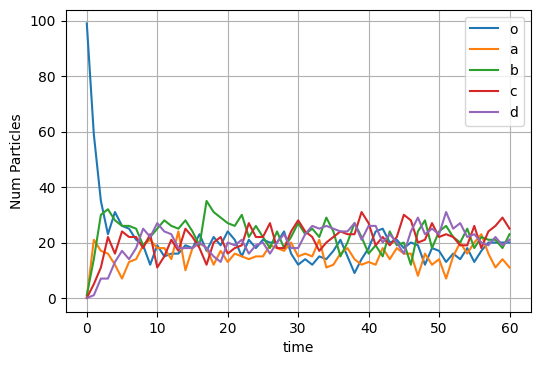

In [38]:
#Plot the number of particles in each node during the simulation

tot_steps = configurations.shape[0]
step = 100

fig = plt.figure(1, figsize=(6,4), dpi=100)
ax = plt.subplot(111)

for node in range(len(G.nodes)):
    node_particles_evolution = configurations[0:tot_steps:step, node]
    ax.plot(node_particles_evolution, label = list(G.nodes)[node])
ax.set_ylabel("Num Particles")
ax.set_xlabel("time")
ax.legend()
plt.grid()

print(f"The last configuration of the system after {tot_steps} is {configurations[-1]}")
print(f"The theoretical invariant distribuion pi_bar is {pi_bar}")

##Problem 3

In this part we study how different particles affect each other when moving around in a network in continuous time. We consider the open network of Figure 2, with transition rate matrix $\Lambda_{open}$ according to:

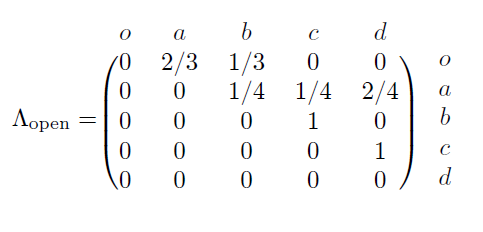

For this system, particles will enter the system at node $o$ according to a Poisson process with rate $λ = 1$. Each node will then pass along a particle according to a given rate, similar to what you did in Problem 2 with the "node perspective".

You will simulate two different scenarios that differ by what rate the nodes will pass along particles: i) $\textit{proportional rate}$, and ii) $\textit{fixed rate}$. 

In scenario $i)$, each node will pass along particles
according to a Poisson process with rate equal to the number of particles in the node. 

In scenario $ii)$, each node will instead pass along particles with a fixed rate of 1. Note that since node $d$ does not have a node to send its particles to, when the Poisson clock ticks for this node you could simply decrease the number of particles in the node by one (if there
are any particles in the node). Equivalently think of another node $d_0$ connected to node d, such that at every tick of the Poisson clock of $d$, it sends a particle to node $d_0$. 

The goal is to simulate the two systems and answer the following questions:

###**a) Proportional rate**

The rate of the Poisson clock of each node is equal to the number of particles in it.


*   Simulate the system for 60 time units and plot the evolution of the number of particles in each node over time.
*   What is the largest input rate that the system can handle without blowing up?



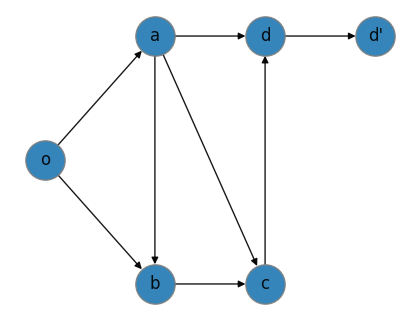

In [39]:
# draw graph
G = nx.DiGraph()
G.add_node('o')
G.add_node('a')
G.add_node('b')
G.add_node('c')
G.add_node('d')
G.add_node("d'")
G.add_edges_from([('o', 'b'), ('o','a'), ('a','b'), ('a','c'), ('b', 'c'), ('a', 'd'), ('c', 'd'), ('d', "d'")])
pos_vertices = {'o': (-1, 0), 'a':(0, 1), 'b':(0, -1), 'c':(1, -1), 'd':(1, 1), "d'":(2,1)}
plt.figure(figsize=(4,3), dpi = 100)
nx.draw(G,pos_vertices, with_labels=True, **options)

In [40]:
lambda_matrix = np.array([
          [0,   2/3, 1/3, 0,   0,   0],
          [0,   0,   1/4, 1/4, 2/4, 0],
          [0,   0,   0,   1,   0,   0],
          [0,   0,   0,   0,   1,   0],
          [0,   0,   0,   0,   0,   1],
          [0,   0,   0,   0,   0,   0]]) # added node d'

n_nodes = len(G.nodes)

w = np.sum(lambda_matrix, axis=1)
w_star = np.max(w)
Q = lambda_matrix/w_star 
Q = Q + np.diag(np.ones(len(w))-np.sum(Q,axis=1))
Q_cum = np.cumsum(Q, axis=1)

In [41]:
print("Number of nodes: ", n_nodes)
print("\nVector w:\n", w)
print("\nMatrix D:\n", D)
print("\nMatrix P:\n", P)
print("\nMatrix P_cum:\n", P_cum)
print("\nMatrix Q:\n", Q)
print("\nMatrix Q_cum:\n", Q_cum)

Number of nodes:  6

Vector w:
 [1. 1. 1. 1. 1. 0.]

Matrix D:
 [[2 0 0 0 0]
 [0 2 0 0 0]
 [0 0 2 0 0]
 [0 0 0 2 0]
 [0 0 0 0 1]]

Matrix P:
 [[0.  0.5 0.5 0.  0. ]
 [0.  0.  0.5 0.5 0. ]
 [0.5 0.  0.  0.5 0. ]
 [0.  0.  0.5 0.  0.5]
 [0.  0.  0.  0.  1. ]]

Matrix P_cum:
 [[0.         0.66666667 1.         1.         1.        ]
 [0.         0.         0.75       1.         1.        ]
 [0.5        0.5        0.5        1.         1.        ]
 [0.         0.         0.33333333 0.33333333 1.        ]
 [0.         0.5        0.5        1.         1.        ]]

Matrix Q:
 [[0.         0.66666667 0.33333333 0.         0.         0.        ]
 [0.         0.         0.25       0.25       0.5        0.        ]
 [0.         0.         0.         1.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         0.         1.        ]
 [0.         0.         0.         0.         0.         1.        ]]

Matrix 

###**a) Proportional rate**


*   Simulate the system for 60 time units and plot the evolution of the number of particles in each node over time.
*   What is the largest input rate that the system can handle without blowing up?



In [42]:
def proportional_rate(in_rate):
  n_steps = 10000
  t_next = -np.log(np.random.rand())/w_star
  t_next_2 = -np.log(np.random.rand())/in_rate

  pos = np.zeros((n_steps, n_nodes))
  pos[0,0] = 0
  transition_times = np.zeros(n_steps)
  transition_times_2 = 0
  i = 0
  while transition_times[i-1] <= 60 and i <= n_steps-1:
    # copy past state
    pos[i,:] = pos[i-1,:] 
    while transition_times_2 <= transition_times[i-1]:
      pos[i,0] = pos[i,0] + 1
      transition_times_2 = transition_times_2 + t_next_2
      t_next_2 = -np.log(np.random.rand())/in_rate

    
    if (pos[i, :-1] == np.zeros(5)).all():
      pos[i,0] = pos[i,0] + 1
      transition_times_2 = transition_times_2 + t_next_2
      t_next_2 = -np.log(np.random.rand())/in_rate
      continue
    else:
      node = np.random.choice(5, p=pos[i,:-1]/np.sum(pos[i,:-1]))
    next_node = np.argwhere(Q_cum[node] > np.random.rand())[0] 
    transition_times[i] = transition_times[i-1] + t_next 
    t_next = -np.log(np.random.rand())/(w_star*np.sum(pos[i,:-1]))
    # node lose one particle
    pos[i,node] = pos[i,node]-1 
    # next node gain one particle
    pos[i,next_node] = pos[i,next_node]+1 
    i+=1
    
    #print("Step ", i)
    #print("Node {} lost 1 particle, node {} gained 1 particle".format(node, next_node))
    #print("Particles distribution: ", pos[i, :])
  return pos, transition_times, i

In [43]:
def plot_proportional_trajectories(pos, transition_times, in_rate):
  fig = plt.figure(figsize=(10,4), dpi=100)
  ax = plt.subplot(111)
  array = ['o', 'a', 'b', 'c', 'd']
  for node in range(n_nodes-1):
      trajectory = pos[:,node]
      ax.plot(transition_times, trajectory, label='node {}'.format(array[node]))
      
  ax.legend()
  ax.set_xlabel("time")
  ax.set_ylabel("Num Particles")
  plt.grid()
  ax.set_title("Input rate : {}".format(in_rate))

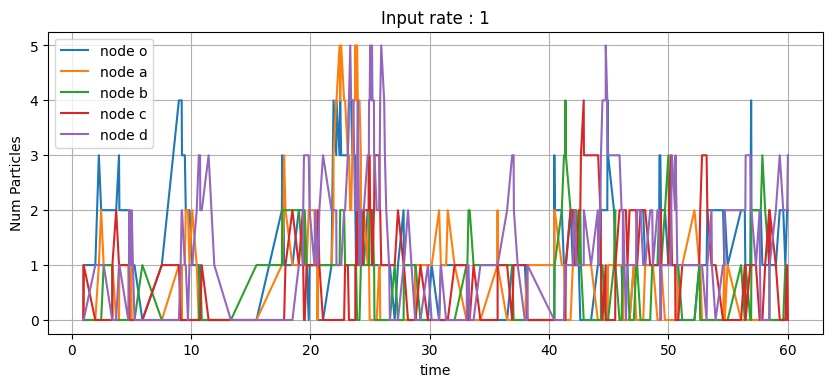

In [98]:
in_rate = 1
pos1, t1, end = proportional_rate(in_rate)
plot_proportional_trajectories(pos1[:end], t1[:end], in_rate)

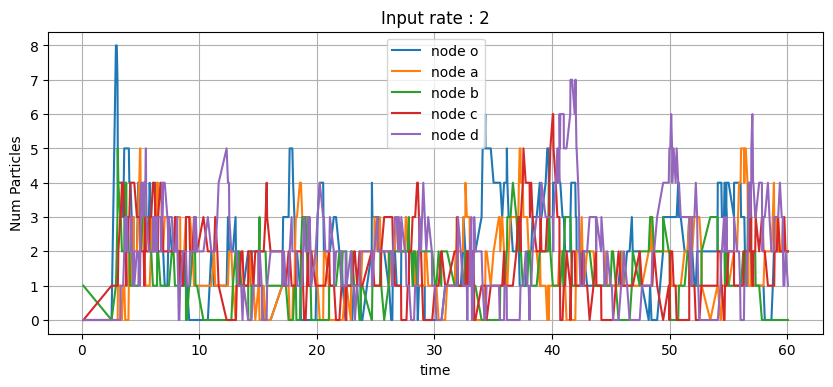

In [97]:
in_rate = 2
pos2, t2, end = proportional_rate(in_rate)
plot_proportional_trajectories(pos2[:end], t2[:end], in_rate)

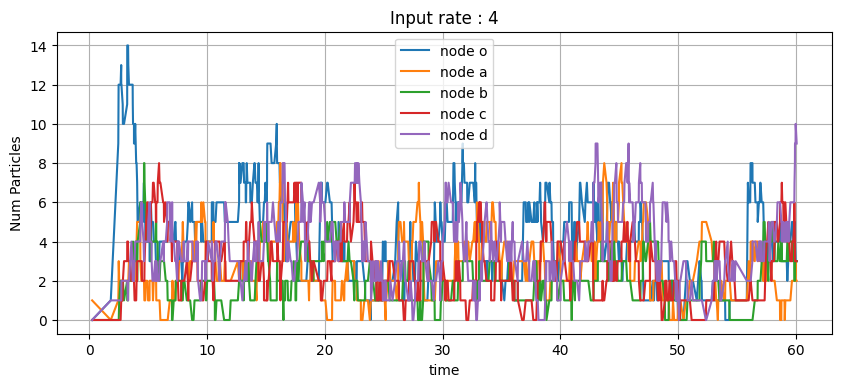

In [96]:
in_rate = 4
pos3, t3, end = proportional_rate(in_rate)
plot_proportional_trajectories(pos3[:end], t3[:end], in_rate)

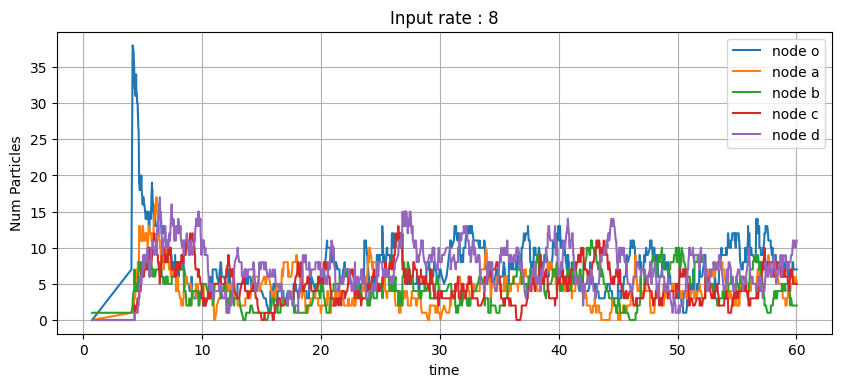

In [94]:
in_rate = 8
pos3, t3, end = proportional_rate(in_rate)
plot_proportional_trajectories(pos3[:end], t3[:end], in_rate)

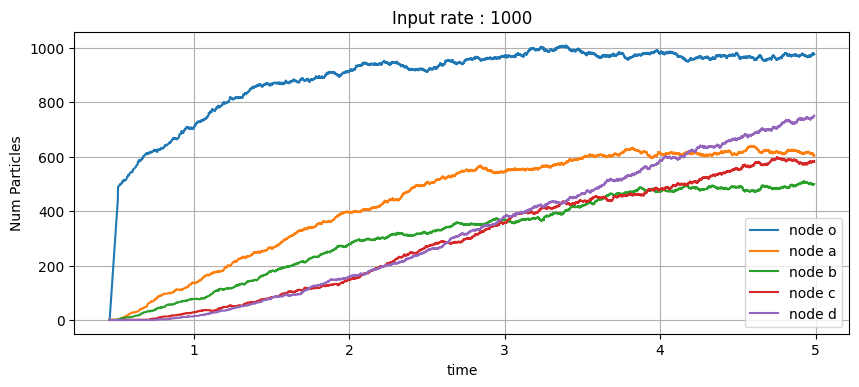

In [93]:
in_rate = 1000
pos3, t3, end = proportional_rate(in_rate)
plot_proportional_trajectories(pos3[:end], t3[:end], in_rate)

###**3b) Fixed rate**



*   Simulate the system for 60 time units and plot the evolution of number of particles in each node over time.
*   What is the largest input rate that the system can handle without blowing up? Why is this different from the other case?



In [79]:
def fixed_rate(in_rate):
  n_steps = 10000
  t_next = -np.log(np.random.rand())/w_star
  t_next_2 = -np.log(np.random.rand())/in_rate

  pos = np.zeros((n_steps, n_nodes))
  pos[0,0] = 0
  transition_times = np.zeros(n_steps)
  transition_times_2 = 0
  i = 0
  while transition_times[i-1] <= 60:
    # copy past state
    pos[i,:] = pos[i-1,:] 
    while transition_times_2 <= transition_times[i-1]:
      pos[i,0] = pos[i,0] + 1
      transition_times_2 = transition_times_2 + t_next_2
      t_next_2 = -np.log(np.random.rand())/in_rate

    
    allowed_nodes = np.argwhere(pos[i,:-1]!=0)

    if (allowed_nodes.size==0):
      pos[i,0] = pos[i,0] + 1
      transition_times_2 = transition_times_2 + t_next_2
      t_next_2 = -np.log(np.random.rand())/in_rate
      
      continue
    else:
      node = np.random.choice(allowed_nodes.flatten())
    next_node = np.argwhere(Q_cum[node] > np.random.rand())[0]
    transition_times[i] = transition_times[i-1] + t_next 
    t_next = -np.log(np.random.rand())/(w_star*5)
    # node lose one particle
    pos[i,node] = pos[i,node]-1 
    # next node gain one particle
    pos[i,next_node] = pos[i,next_node]+1 
    i+=1
    
  return pos, transition_times, i

In [80]:
def plot_fixed_trajectories(pos, transition_times, in_rate):
  fig = plt.figure(figsize=(10,6), dpi=100)
  ax = plt.subplot(111)
  array = ['o', 'a', 'b', 'c', 'd']
  for node in range(n_nodes-1):
      trajectory = pos[:,node]
      ax.plot(transition_times, trajectory, label='node {}'.format(array[node]))
      
  ax.legend()
  ax.set_xlabel("time")
  ax.set_ylabel("Num Particles")
  plt.grid()
  ax.set_title("Input rate : {}".format(in_rate))

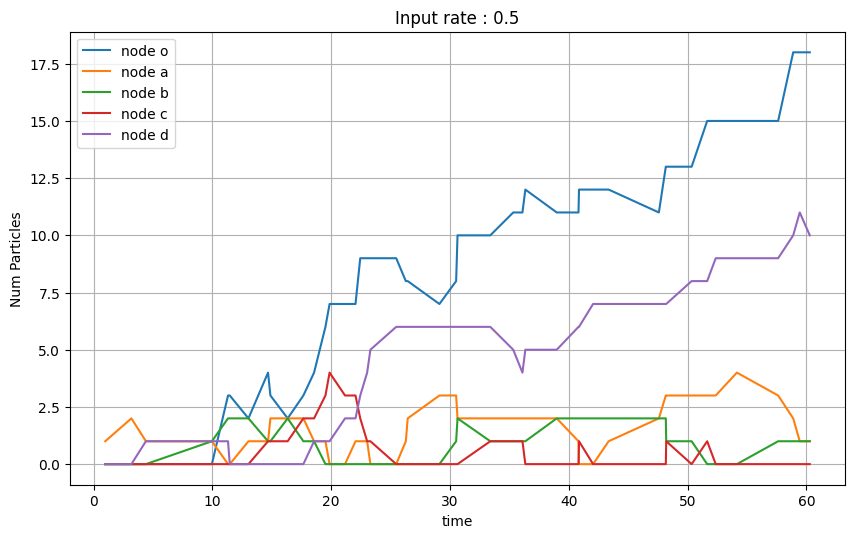

In [81]:
in_rate = 0.5
pos1, t1, end = fixed_rate(in_rate)
plot_fixed_trajectories(pos1[:end], t1[:end], in_rate)

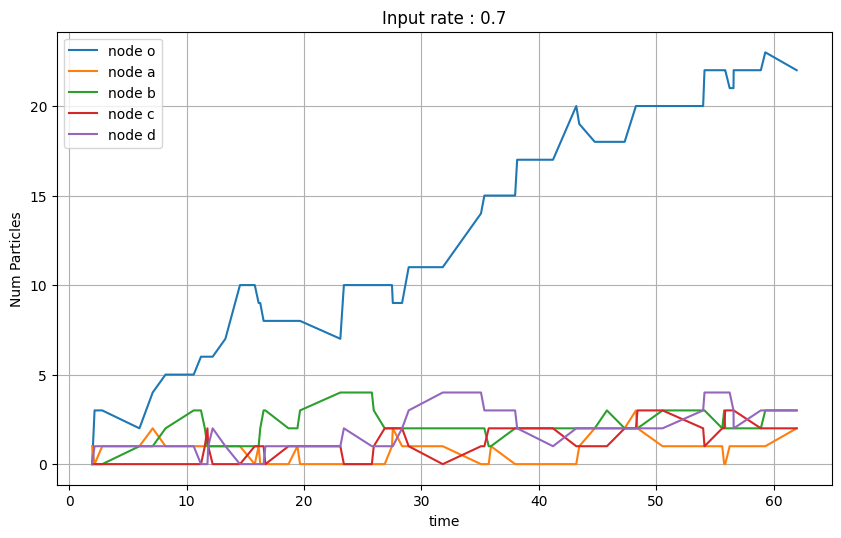

In [82]:
in_rate = 0.7
pos2, t2, end = fixed_rate(in_rate)
plot_fixed_trajectories(pos2[:end],t2[:end],in_rate)

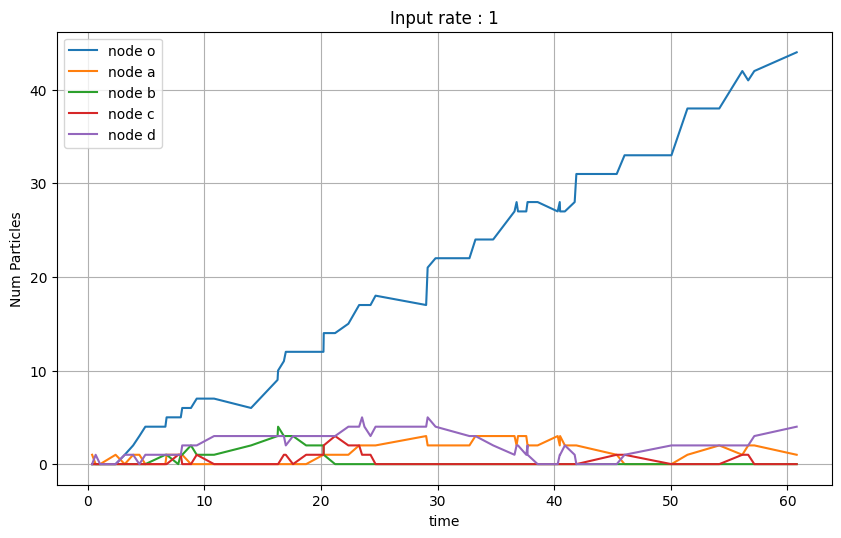

In [83]:
in_rate = 1
pos3, t3, end = fixed_rate(in_rate)
plot_fixed_trajectories(pos3[:end],t3[:end],in_rate)

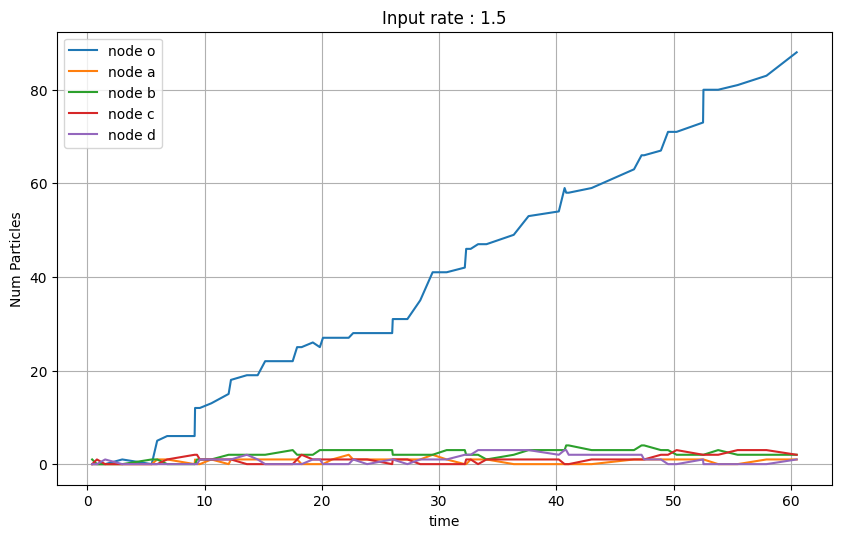

In [103]:
in_rate = 1.5
pos4,t4, end = fixed_rate(in_rate)
plot_fixed_trajectories(pos4[:end] ,t4[:end] ,in_rate)

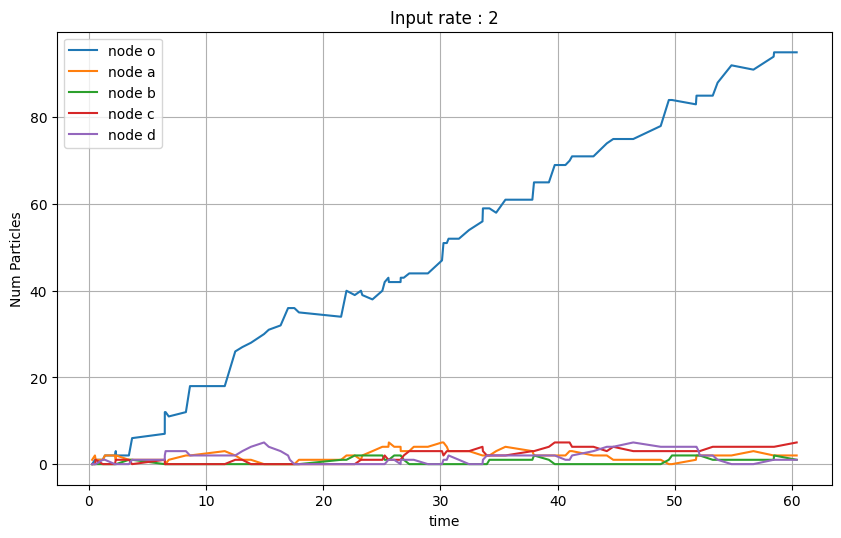

In [102]:
in_rate = 2
pos4,t4, end = fixed_rate(in_rate)
plot_fixed_trajectories(pos4[:end] ,t4[:end] ,in_rate)